In [1]:
import os, sys

import glob
import zipfile

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
%matplotlib inline

In [2]:
plt.style.use('seaborn') # seaborn 스타일로 변환
sns.set(rc={'figure.figsize' : (15,7)})
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)
warnings.filterwarnings('ignore')

# 0. 대회 설명

 - 대회 : https://www.kaggle.com/c/titanic
 - 주제 : predicts which passengers survived the trainanic shipwreck
 - 문제 정의 : 어떤 특징의 승객이 살아남을 확률이 높을 것인가
 - Data Description
     - survival	 Survival	0 = No, 1 = Yes
     - pclass	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
     - sex	Sex	
     - Age	Age in years
     - sibsp	# of siblings / spouses aboard the Titanic	
     - parch	# of parents / children aboard the Titanic	
     - ticket	Ticket number	
     - fare	Passenger fare	
     - cabin	Cabin number	
     - embarked	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

# 1. Data Load

In [3]:
!kaggle competitions download -c titanic

titanic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
os.listdir()

['.DS_Store', 'titanic.zip', '.ipynb_checkpoints', 'data', 'Titanic.ipynb']

In [5]:
unzip = zipfile.ZipFile('titanic.zip')
unzip.extractall(path = 'data')

In [6]:
os.listdir('./data/')

['test.csv',
 'submission_soft.csv',
 'train.csv',
 'gender_submission.csv',
 'submission_hard.csv']

In [7]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [8]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
train.nunique()

PassengerId    891
Survived         2
Pclass           3
Name           891
Sex              2
Age             88
SibSp            7
Parch            7
Ticket         681
Fare           248
Cabin          147
Embarked         3
dtype: int64

In [11]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# 2. EDA

## 2-1. Label (Survived)

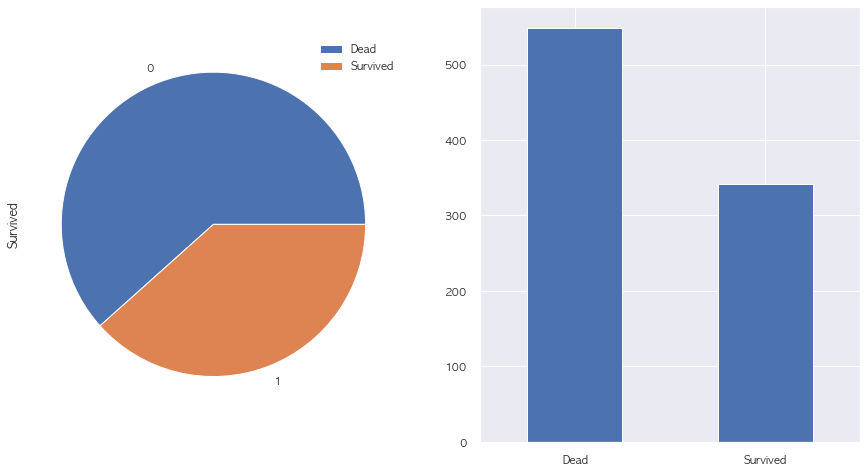

In [12]:
# 생존 / 사망 비율
#  0, Dead / 1, Survived
f, ax = plt.subplots(1, 2, figsize=(15,8))
train['Survived'].value_counts().plot.pie(rot = 0, ax = ax[0])
ax[0].legend(['Dead', 'Survived'])
train['Survived'].value_counts().plot.bar(rot = 0, ax = ax[1])
ax[1].set_xticklabels(labels = ['Dead', 'Survived'])
plt.show()

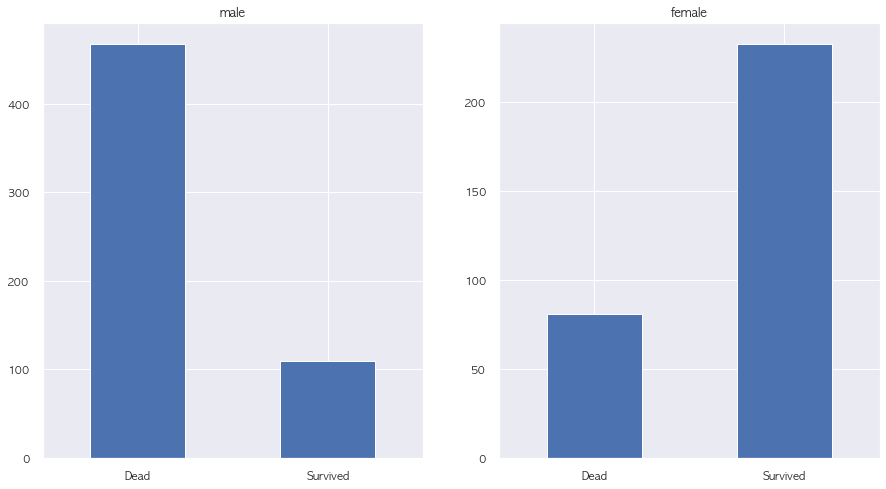

In [13]:
# 성별별 사망 비율
f, ax = plt.subplots(1, 2, figsize=(15,8))
train.loc[train['Sex'] == 'male', 'Survived'].value_counts().sort_index().plot.bar(rot = 0, ax = ax[0])
ax[0].set_title('male')
ax[0].set_xticklabels(['Dead', 'Survived'])
train.loc[train['Sex'] == 'female', 'Survived'].value_counts().sort_index().plot.bar(rot = 0, ax = ax[1])
ax[1].set_title('female')
ax[1].set_xticklabels(['Dead', 'Survived'])
plt.show()

In [14]:
# P_class 별 생존여부
pd.pivot_table(train, index = 'Pclass', columns = 'Survived', values = 'Name', aggfunc='count', fill_value=0)
# pd.crosstab(train['Pclass'], train['Survived']) # 똑같은 결과

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


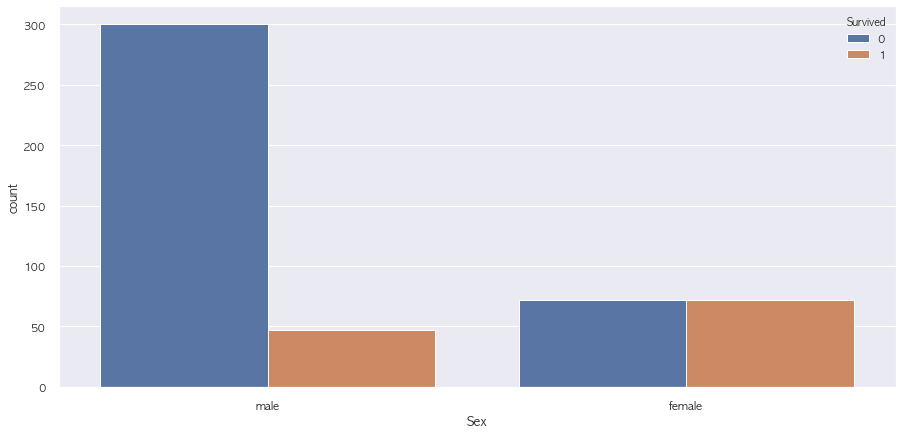

In [15]:
# Pclass가 3인 경우, 죽은 인원과 비율이 굉장히 많고 높음
# 보통 Pclasss는 남성인 경우가 많지만 생존된 비율은 여성이 더 높음
sns.countplot(data = train.loc[train['Pclass'] == 3], x = 'Sex', hue = 'Survived')
plt.show()

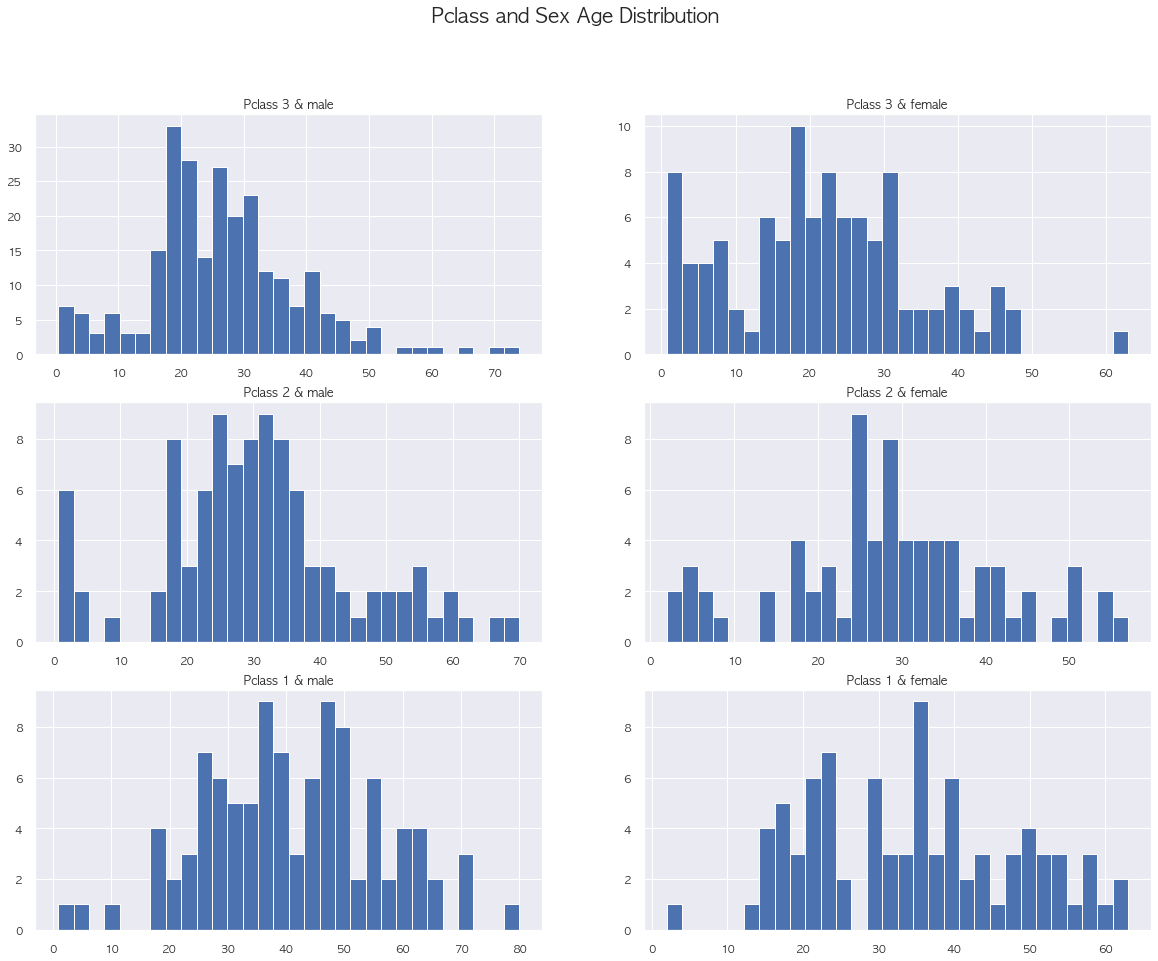

In [16]:
# Pclass별 차이 확인
# Pclass & sex 별 나이 분포도
# Pclass 1->3 으로 갈수록 나이 분포가 점차 낮아지는 것을 확인 가능

f, ax = plt.subplots(3,2, figsize = (20, 15))
train.loc[(train['Pclass'] == 3) & (train['Sex'] == 'male'), 'Age'].hist(bins = 30, ax = ax[0][0])
train.loc[(train['Pclass'] == 3) & (train['Sex'] == 'female'), 'Age'].hist(bins = 30, ax = ax[0][1])
ax[0][0].set_title('Pclass 3 & male')
ax[0][1].set_title('Pclass 3 & female')

train.loc[(train['Pclass'] == 2) & (train['Sex'] == 'male'), 'Age'].hist(bins = 30, ax = ax[1][0])
train.loc[(train['Pclass'] == 2) & (train['Sex'] == 'female'), 'Age'].hist(bins = 30, ax = ax[1][1])
ax[1][0].set_title('Pclass 2 & male')
ax[1][1].set_title('Pclass 2 & female')

train.loc[(train['Pclass'] == 1) & (train['Sex'] == 'male'), 'Age'].hist(bins = 30, ax = ax[2][0])
train.loc[(train['Pclass'] == 1) & (train['Sex'] == 'female'), 'Age'].hist(bins = 30, ax = ax[2][1])
ax[2][0].set_title('Pclass 1 & male')
ax[2][1].set_title('Pclass 1 & female')

plt.suptitle('Pclass and Sex Age Distribution', fontsize = 20)

plt.show()

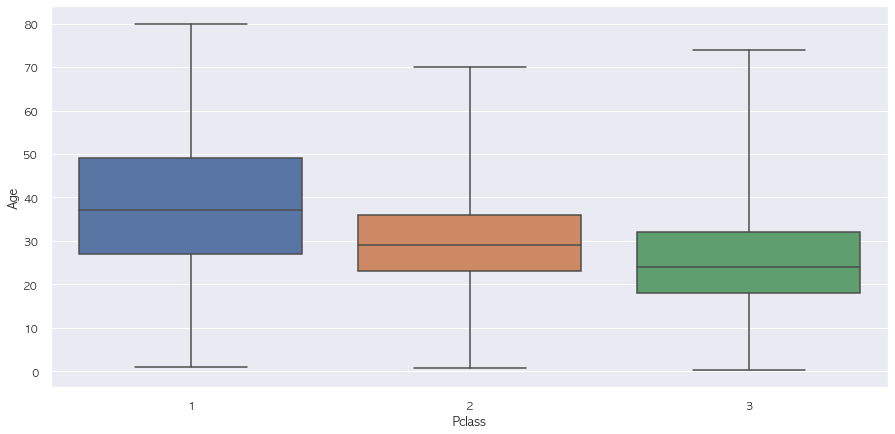

In [17]:
# boxplot 확인 결과 확실히 Pclass 낮을수록 연령대가 높음
sns.boxplot(x="Pclass", y="Age", data=train, whis=np.inf)
plt.show()

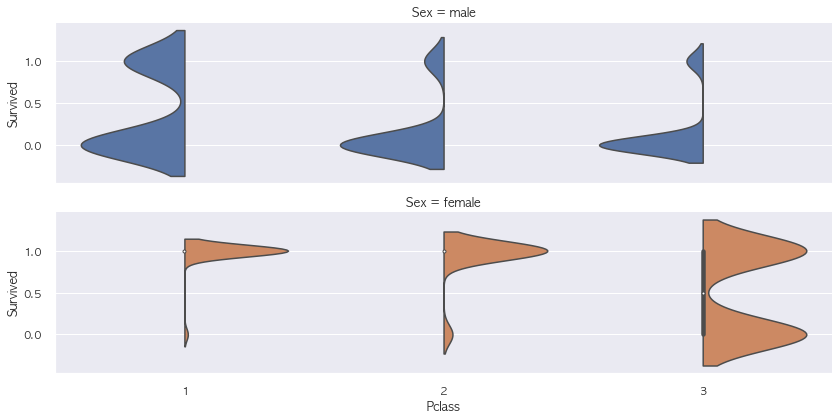

In [18]:
# Pclass $ sex 별 survived 분포
# Pclass 3->1 으로 갈수록 남성이 생존하는 비율이 높아지고
# Pclass 1 인 경우에는 여성이 사망하는 경우가 거의 없음
# 결론적으로, Pclass는 좀 더 고위층인 느낌인 들며 Survived(0/1)에 생각보다 영향을 많이 미치는 것 같음
sns.catplot(x = "Pclass", y = "Survived", hue = "Sex", row = "Sex", data = train,
            kind = "violin", split = True, height = 3, aspect = 4)
plt.show()

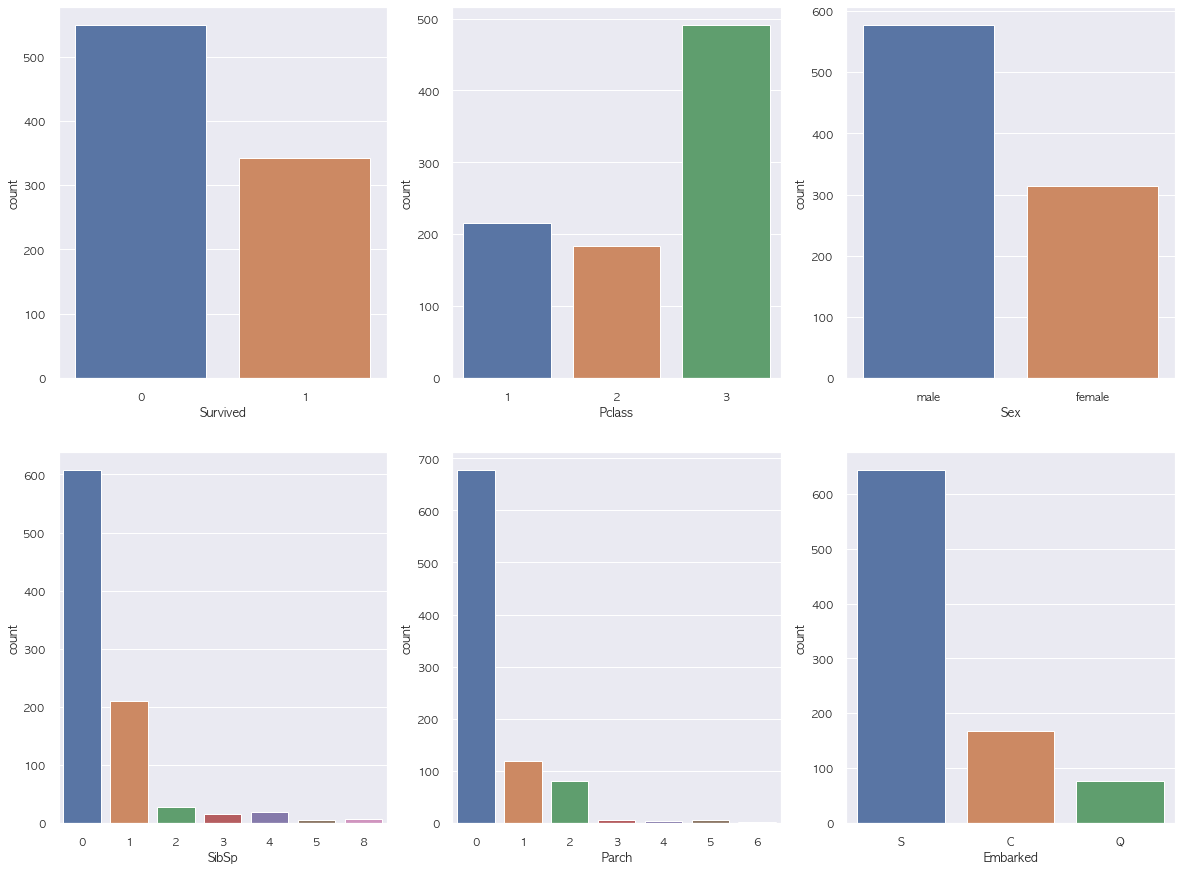

In [19]:
# 단순 feature에 대한 countplot
f, ax = plt.subplots(2,3, figsize = (20, 15))
columns = ['Survived', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
q = 0

for i in range(2):
    for j in range(3):
        fig = sns.countplot(x = train[columns[q]], ax = ax[i][j])
        q += 1

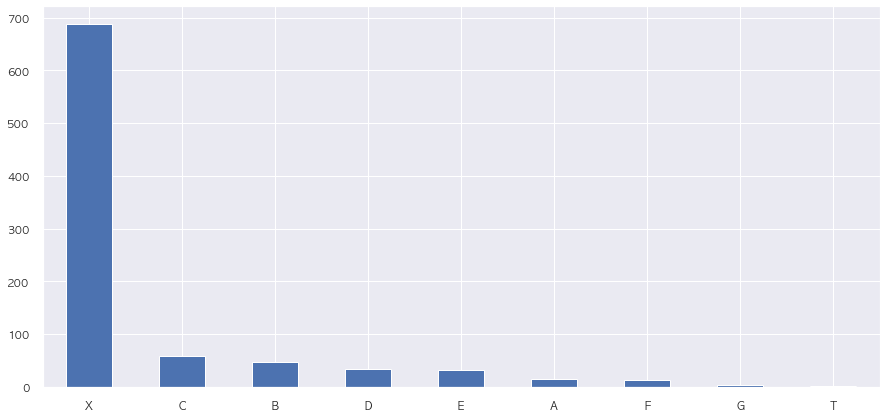

In [20]:
# Cabin 은 정확히 어떤 의미인지는 모르지만, NaN 인 경우가 많음
# Cabin: a small room where you sleep in a ship
# 선실의 종류를 의미하는 것 같기 때문에 Pclass와 같이 보면 좋을 것 같음
train['Cabin'].fillna('X').apply(lambda x : x[:1]).value_counts().plot.bar(rot = 0)
plt.show()

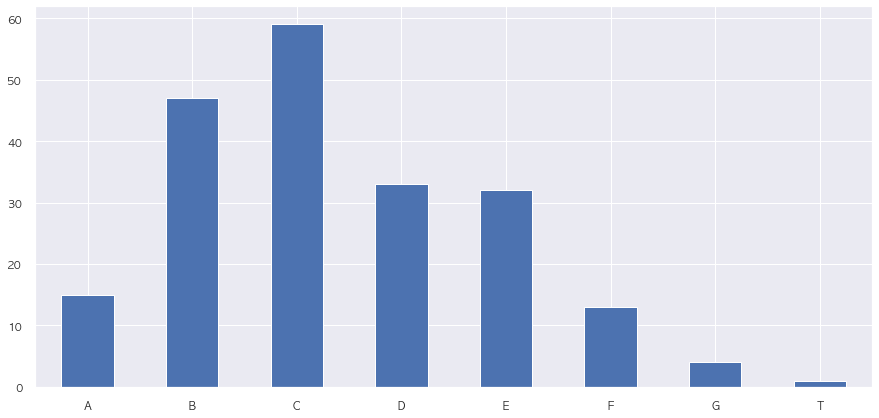

In [21]:
# NaN 제외 Cabin 분포
data = []
train.loc[train['Cabin'].notnull(), 'Cabin'].apply(lambda x : data.extend(x[:1]))
pd.Series(data).value_counts().sort_index().plot.bar(rot = 0)
plt.show()

In [22]:
Pclass_cabin = train.loc[train['Cabin'].notnull(), ['Survived', 'Pclass', 'Cabin', 'Fare']]
Pclass_cabin['Cabin'] = Pclass_cabin['Cabin'].apply(lambda x : x[:1])
Pclass_cabin.head()

,Survived,Pclass,Cabin,Fare
1,1,1,C,71.2833
3,1,1,C,53.1000
6,0,1,E,51.8625
10,1,3,G,16.7000
11,1,1,C,26.5500


In [23]:
# 흠.. 모집단이 너무 작아 확실한 결론을 내리기가 애매하지만..
# 일단 Pclass 1은 F, G, T 에는 거의 없음
pd.pivot_table(Pclass_cabin, index = 'Pclass', columns = 'Cabin', values = 'Survived', aggfunc = 'count')

Cabin,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,15.0,47.0,59.0,29.0,25.0,NaN,NaN,1.0
2,NaN,NaN,NaN,4.0,4.0,8.0,NaN,NaN
3,NaN,NaN,NaN,NaN,3.0,5.0,4.0,NaN


In [24]:
# 확실히 Pclass가 높을수록 생존 가능성이 높다는 가설이 맞는것...같은...
# 그렇다면 비어있는 cabin에 대한 처리를 어떤식으로 할 수 있을까!
# 만약 Cabin 이 선실에 대한 의미이면 Fare(요금?)이랑 연관이 있지 않을까?!
pd.pivot_table(Pclass_cabin, index = 'Survived', columns = 'Cabin', values = 'Pclass', aggfunc = 'count')

Cabin,A,B,C,D,E,F,G,T
Survived,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN


In [25]:
# 오오.. 확실히 Pclass 1의 Cabin의 fare가 높음
pd.pivot_table(Pclass_cabin, index = 'Pclass', columns = 'Cabin', values = 'Fare', aggfunc = np.mean)

Cabin,A,B,C,D,E,F,G,T
Pclass,,,,,,,,
1,39.623887,113.505764,100.151341,63.324286,55.740168,NaN,NaN,35.5
2,NaN,NaN,NaN,13.166675,11.587500,23.75000,NaN,NaN
3,NaN,NaN,NaN,NaN,11.000000,10.61166,13.58125,NaN


In [26]:
pd.pivot_table(Pclass_cabin, index = 'Survived', columns = 'Cabin', values = 'Fare', aggfunc = np.median)

Cabin,A,B,C,D,E,F,G,T
Survived,,,,,,,,
0,37.3896,42.7500,81.1625,43.5604,45.18125,7.65000,10.4625,35.5
1,35.5000,91.0792,89.1042,63.3583,39.82500,24.17915,16.7000,NaN


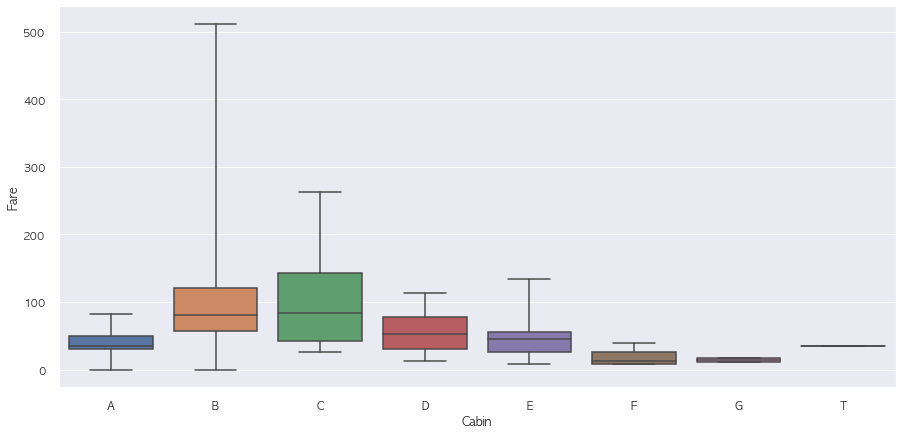

In [27]:
# Fare가 10 이하일 경우에는 F, G 랜덤 부여
# Fare가 10 초과 50 이하일 경우에는 A, D, E, T
# Fare가 50 초과일 경우에는 B, C
sns.boxplot(x = "Cabin", y = "Fare", data = Pclass_cabin.sort_values('Cabin'), whis=np.inf)
plt.show()

In [28]:
# 이름에서 생존여부 차이를 알 수 있을까

In [29]:
train.loc[(train['Name'].str.contains('Mr')) & (train['Name'].str.contains('Mrs') == False)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


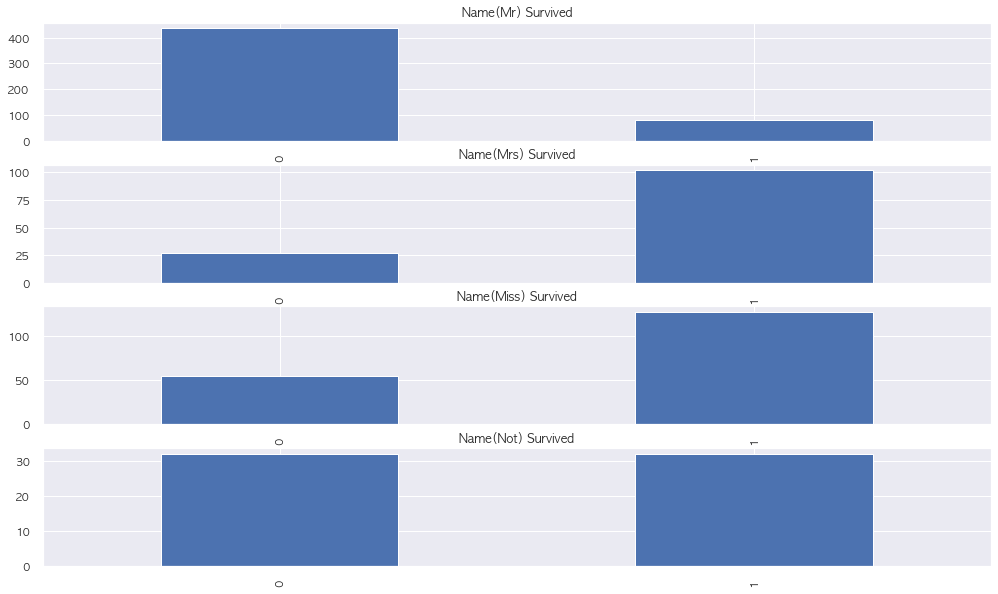

In [30]:
# 이름 에서 찾을 수 있는 성별 및 결혼 여부
# 남자 기혼인 경우에
f, ax = plt.subplots(4,1, figsize = (17, 10))

train.loc[(train['Name'].str.contains('Mr')) & (train['Name'].str.contains('Mrs') == False), 'Survived'].value_counts().sort_index().plot.bar(ax = ax[0])
ax[0].set_title('Name(Mr) Survived')

train.loc[train['Name'].str.contains('Mrs'), 'Survived'].value_counts().sort_index().plot.bar(ax = ax[1])
ax[1].set_title('Name(Mrs) Survived')

train.loc[train['Name'].str.contains('Miss'), 'Survived'].value_counts().sort_index().plot.bar(ax = ax[2])
ax[2].set_title('Name(Miss) Survived')

train.loc[~train['Name'].str.contains('Mr|Miss|Mrs'), 'Survived'].value_counts().sort_index().plot.bar(ax = ax[3])
ax[3].set_title('Name(Not) Survived')

plt.show()

In [31]:
train['Agegroup'] = train['Age'].apply(lambda x : 'baby' if (x > 0) & (x < 5) else (
            'Child' if (x > 5) & (x <= 12) else(
            'Teenager' if (x > 12) & (x <= 18) else(
            'Student' if (x > 18) & (x <= 24) else(
            'Young Adult' if (x > 24) & (x <= 35) else(
            'Adult' if (x > 35) & (x <= 60) else(
            'Senior' if x > 60 else 'Unknown'
            )))))))

In [32]:
pd.pivot_table(train, index = 'Pclass', columns = 'Agegroup', values = 'Fare', aggfunc = np.mean)

Agegroup,Adult,Child,Senior,Student,Teenager,Unknown,Young Adult,baby
Pclass,,,,,,,,
1,76.983334,120.00000,59.96905,114.781878,122.537500,60.551940,92.497581,128.319433
2,19.760638,30.56250,10.50000,25.048852,21.172567,9.584375,19.773205,28.215283
3,13.334195,27.32625,7.82000,9.085753,13.414589,14.973859,11.634408,22.912832


# 3. Preprocessing

In [33]:
from sklearn.base import BaseEstimator, TransformerMixin

In [34]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Agegroup
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Student
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Adult
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Young Adult
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Young Adult
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Young Adult


In [35]:
class preprocessing(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        # 나이 null값 채우기
        temp = pd.pivot_table(X, index = 'Pclass', columns = 'Sex', values = 'Age', aggfunc = np.median)
        
        for pclass, sex in X.loc[X['Age'].isnull(), ['Pclass', 'Sex']].drop_duplicates().values:
            X.loc[(X['Age'].isnull()) & (X['Pclass'] == pclass) & (X['Sex'] == sex), 'Age'] = temp.loc[pclass, sex]
        
        # 나이 그룹 피처 생성
        X['Agegroup'] = X['Age'].apply(lambda x : 'baby' if (x > 0) & (x < 5) else (
            'Child' if (x > 5) & (x <= 12) else(
            'Teenager' if (x > 12) & (x <= 18) else(
            'Student' if (x > 18) & (x <= 24) else(
            'Young Adult' if (x > 24) & (x <= 35) else(
            'Adult' if (x > 35) & (x <= 60) else(
            'Senior' if x > 60 else 'Unknown'
            )))))))
        
        # cabin 피쳐 전처리
        X['Cabin'] = X['Cabin'].fillna('X').apply(lambda x : x[:1])
        X.loc[X['Cabin'] == 'X', 'Cabin'] = (X.apply(lambda x: np.random.choice(['F', 'G']) if x['Fare'] <= 10 else (
                                                               np.random.choice(['A', 'D', 'E', 'T']) if x['Fare'] > 10 and x['Fare'] < 50 else
                                                               np.random.choice(['B', 'C'])
                                                     ), axis = 1))
        
        
        # 티켓 글자 포함 여부
        X['Ticket'] = X['Ticket'].apply(lambda x : 1 if x.isalnum() else 0)
        
        # Fare qcut
        X['Fare_qcut'] = pd.qcut(X['Fare'], 5, labels = False)
        
        # 이름별 특징 정리
        X['Name'] = X['Name'].apply(lambda x : 0 if 'Mrs' in x or 'Miss' in x else (1 if 'Mr' in x else 3)).astype(str)
        
        #
        INDEX = ['PassengerId']
        Y = ['Survived']
        
        CONTINUOUS = ['Age', 'Fare', 'Fare_qcut']
        CATEGORICAL = ['Cabin', 'Pclass', 'SibSp', 'Parch', 'Name', 'Sex', 'Agegroup', 'Ticket', 'Embarked']
        
        INPUT = pd.concat([pd.get_dummies(X[CATEGORICAL]), X[CONTINUOUS]], axis = 1)
        try:
            OUTPUT = X[Y]
        except:
            OUTPUT = None
            
        return INPUT, OUTPUT

In [36]:
train = pd.read_csv(os.path.join('data', 'train.csv'))
test = pd.read_csv(os.path.join('data', 'test.csv'))

In [37]:
preprocessing = preprocessing()

In [38]:
X, Y = preprocessing.fit_transform(train)

In [39]:
X

,Pclass,SibSp,Parch,Ticket,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,...,Agegroup_Teenager,Agegroup_Unknown,Agegroup_Young Adult,Agegroup_baby,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,Fare_qcut
0,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,22.0,7.2500,0
1,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,38.0,71.2833,4
2,3,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,26.0,7.9250,1
3,1,1,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,35.0,53.1000,4
4,3,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,35.0,8.0500,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,27.0,13.0000,2
887,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,19.0,30.0000,3
888,3,1,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,21.5,23.4500,3
889,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,26.0,30.0000,3


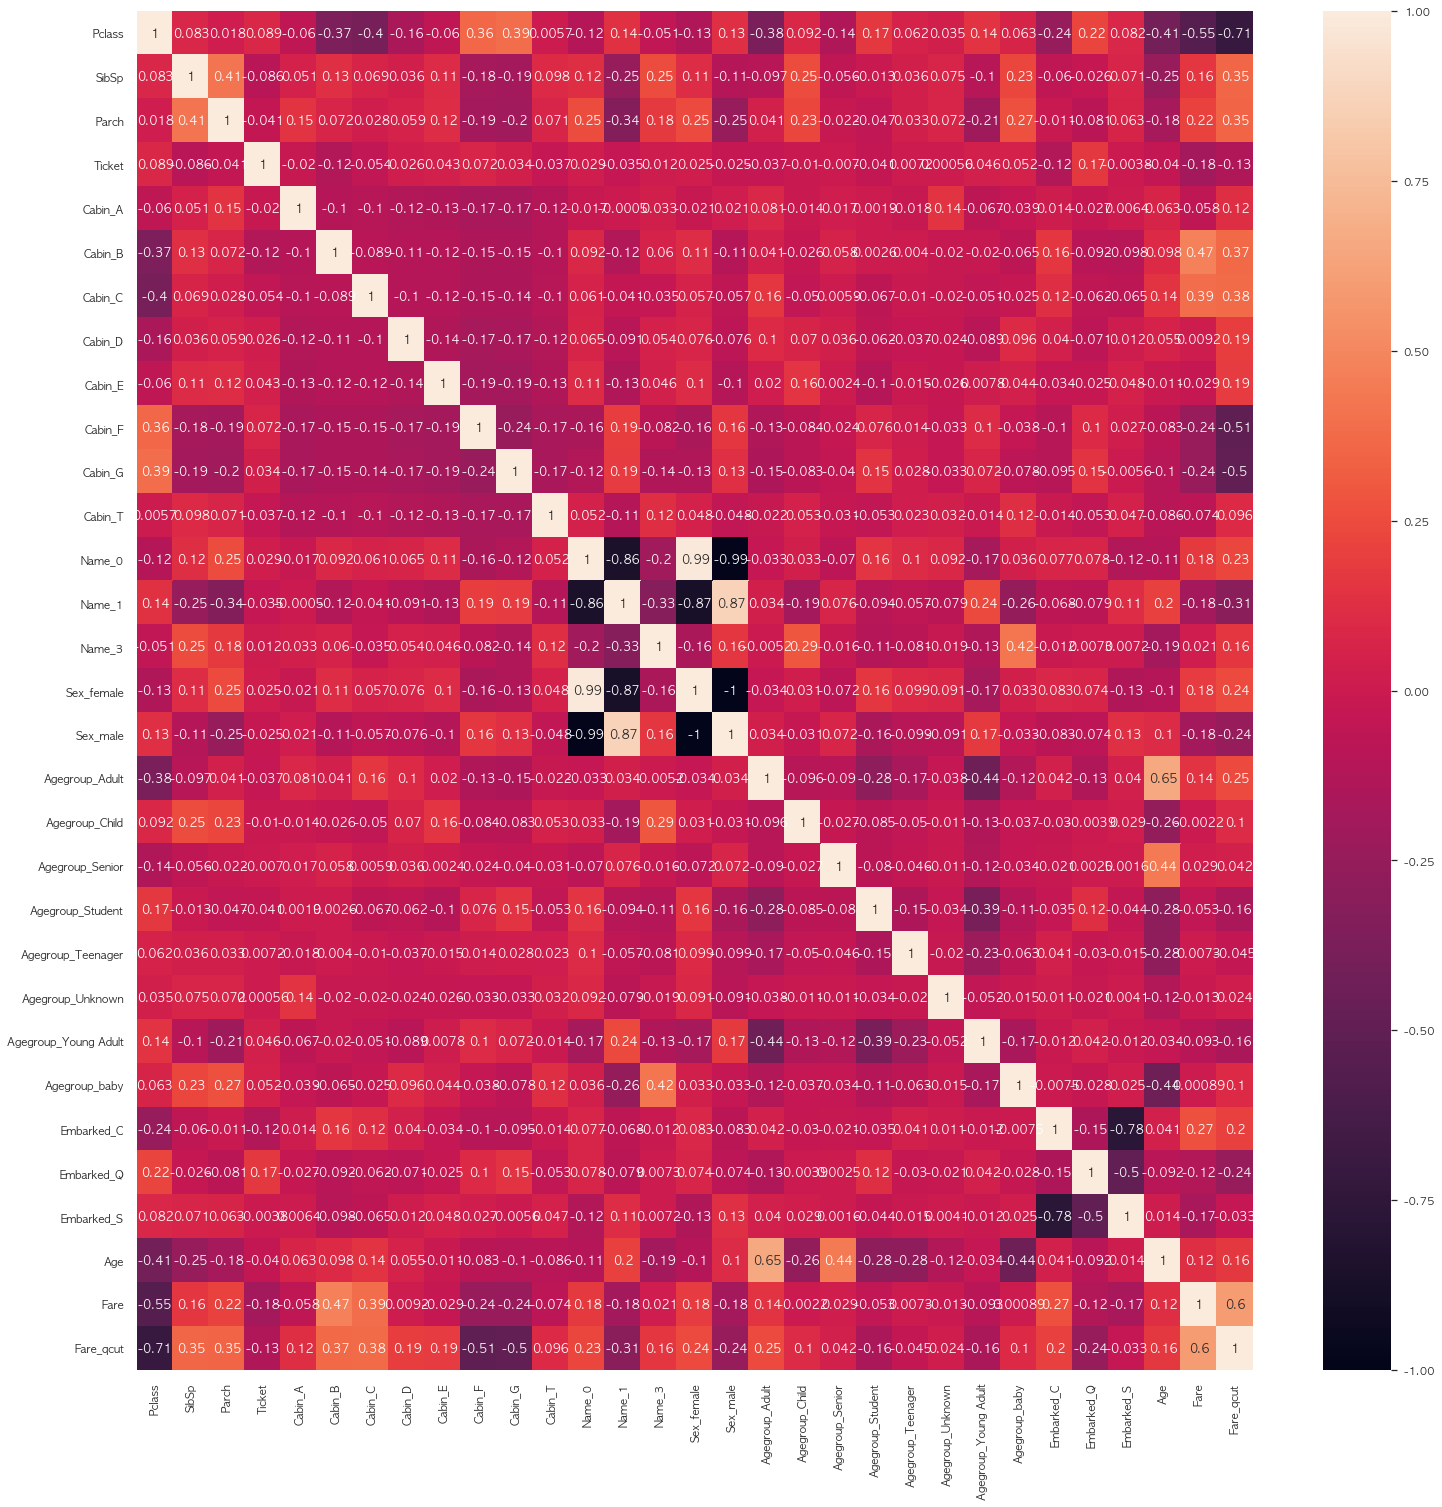

In [40]:
plt.figure(figsize = (25, 25))
sns.heatmap(X.corr(), annot = True)
plt.show()

# 4. Model

## 4-1. Baseline

In [41]:
from sklearn import model_selection
from sklearn import ensemble, gaussian_process, linear_model, naive_bayes, neighbors, svm, tree, discriminant_analysis
from xgboost import XGBClassifier

In [42]:
# 베이스 모델
MODELS = [
    # 앙상블 모델
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    # 가우시안 모델
    gaussian_process.GaussianProcessClassifier(),
    
    # 선형 모델
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    # 나이브베이지안 모델
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    # 이웃기반 모델
    neighbors.KNeighborsClassifier(),
    
    # SVM
    svm.SVC(probability = True),
    svm.NuSVC(probability = True),
    svm.LinearSVC(),
    
    # 트리 모델
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    # 선형판별분석
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    # xgboost
    XGBClassifier()    
    ]

# cross validation
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = 0.2, train_size = 0.8, random_state = 42 ) # run model 10x with 60/30 split intentionally leaving out 10%

# 모델 비교를 위한 데이터프레임 생성
Model_columns = ['Model Name', 'Model Parameters', 'Model Train Accuracy Mean', 'Model Test Accuracy Mean', 'Model Test Accuracy 3*STD' ,'Model Time']
Model_compare = pd.DataFrame(columns = Model_columns)

In [45]:
# 모델별 predict 결과 저장
Model_predict = Y.copy()

# MLA_compare 데이터프레임에 각 모델 결과 저장
row_index = 0
for alg in MODELS:

    # 모델별 base Parameter
    Model_name = alg.__class__.__name__
    Model_compare.loc[row_index, 'Model Name'] = Model_name
    Model_compare.loc[row_index, 'Model Parameters'] = str(alg.get_params())
    
    cv_results = model_selection.cross_validate(alg, X = X, y = Y, cv = cv_split, return_train_score = True)

    Model_compare.loc[row_index, 'Model Time'] = cv_results['fit_time'].mean()
    Model_compare.loc[row_index, 'Model Train Accuracy Mean'] = cv_results['train_score'].mean() # cross_validate에서 'train_score' 나오지 않음
    Model_compare.loc[row_index, 'Model Test Accuracy Mean'] = cv_results['test_score'].mean()   
    Model_compare.loc[row_index, 'Model Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    

    # 모델별 predict 값 저장
    alg.fit(X, Y)
    Model_predict[Model_name] = alg.predict(X)
    
    row_index+=1

In [46]:
Model_compare = Model_compare.sort_values('Model Test Accuracy Mean', ascending = False).reset_index(drop = True)
Model_compare

,Model Name,Model Parameters,Model Train Accuracy Mean,Model Test Accuracy Mean,Model Test Accuracy 3*STD,Model Time
0,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.992837,0.834078,0.0691227,0.130805
1,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.889747,0.832402,0.0599616,0.115466
2,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.91264,0.830168,0.0438325,0.0973389
3,BaggingClassifier,"{'base_estimator': None, 'bootstrap': True, 'b...",0.975421,0.82514,0.0653631,0.0259796
4,RidgeClassifierCV,"{'alphas': array([ 0.1, 1. , 10. ]), 'class_w...",0.816152,0.821788,0.0958243,0.00842168
5,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.81559,0.820112,0.0993786,0.00630891
6,LogisticRegressionCV,"{'Cs': 10, 'class_weight': None, 'cv': None, '...",0.818118,0.815084,0.0708881,0.919542
7,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator': Non...",0.835815,0.811732,0.0838156,0.0705613
8,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.992837,0.806704,0.0821742,0.118113
9,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.809831,0.801117,0.109183,0.102566


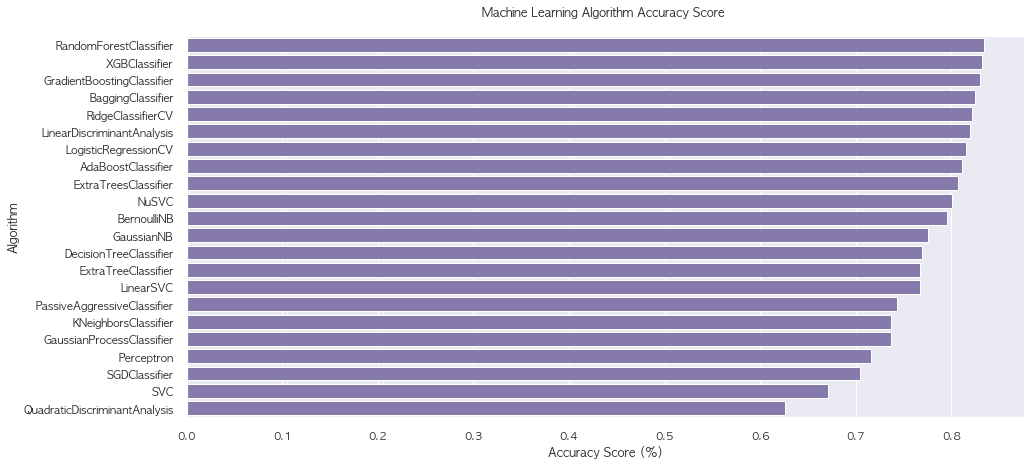

In [47]:
sns.barplot(x = 'Model Test Accuracy Mean', y = 'Model Name', data = Model_compare, color = 'm')

plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')
plt.show()

## 4-2. Ensemble

In [48]:
# 상위 10개 모델만 선정
TOP = []
for name in Model_compare['Model Name'].values:
    for alg in MODELS:
        if name in str(alg):
            try: # predict_proba 가 존재하는 모델만 선별
                alg.predict_proba
                v = (name, alg)
                TOP.append(v)
            except:
                pass

In [49]:
TOP

[('RandomForestClassifier', RandomForestClassifier()),
 ('XGBClassifier', XGBClassifier()),
 ('GradientBoostingClassifier', GradientBoostingClassifier()),
 ('BaggingClassifier', BaggingClassifier()),
 ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('LogisticRegressionCV', LogisticRegressionCV()),
 ('AdaBoostClassifier', AdaBoostClassifier()),
 ('ExtraTreesClassifier', ExtraTreesClassifier()),
 ('NuSVC', NuSVC(probability=True)),
 ('BernoulliNB', BernoulliNB()),
 ('GaussianNB', GaussianNB()),
 ('DecisionTreeClassifier', DecisionTreeClassifier()),
 ('ExtraTreeClassifier', ExtraTreeClassifier()),
 ('KNeighborsClassifier', KNeighborsClassifier()),
 ('GaussianProcessClassifier', GaussianProcessClassifier()),
 ('SVC', SVC(probability=True)),
 ('SVC', NuSVC(probability=True)),
 ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis())]

In [50]:
vote_est = TOP[:9]

In [51]:
vote_est

[('RandomForestClassifier', RandomForestClassifier()),
 ('XGBClassifier', XGBClassifier()),
 ('GradientBoostingClassifier', GradientBoostingClassifier()),
 ('BaggingClassifier', BaggingClassifier()),
 ('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()),
 ('LogisticRegressionCV', LogisticRegressionCV()),
 ('AdaBoostClassifier', AdaBoostClassifier()),
 ('ExtraTreesClassifier', ExtraTreesClassifier()),
 ('NuSVC', NuSVC(probability=True))]

In [88]:
def voting(model_candidates):
    
    N = len(model_candidates)
    
    for i in reversed(range(2, N+1)):
        vote_est = model_candidates[:i]
        
        print('=' * 15, f'voting {i} Model', '=' * 15)
        vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
        vote_hard_cv = model_selection.cross_validate(vote_hard, X, Y, cv  = cv_split)
        vote_hard.fit(X, Y)

        print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
        print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
        print('-' * 40)

        # Soft Vote
        vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
        vote_soft_cv = model_selection.cross_validate(vote_soft, X, Y, cv  = cv_split)
        vote_soft.fit(X, Y)
        vote_soft_pred = vote_soft.predict(X)

        print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
        print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
        print('=' * 40)

In [89]:
voting(vote_est)

=============== voting 9 Model ===============
Hard Voting Test w/bin score mean: 83.46
Hard Voting Test w/bin score 3*std: +/- 7.69
----------------------------------------
Soft Voting Test w/bin score mean: 84.02
Soft Voting Test w/bin score 3*std: +/- 6.01
=============== voting 8 Model ===============
Hard Voting Test w/bin score mean: 83.35
Hard Voting Test w/bin score 3*std: +/- 5.99
----------------------------------------
Soft Voting Test w/bin score mean: 83.69
Soft Voting Test w/bin score 3*std: +/- 4.90
=============== voting 7 Model ===============
Hard Voting Test w/bin score mean: 83.24
Hard Voting Test w/bin score 3*std: +/- 6.14
----------------------------------------
Soft Voting Test w/bin score mean: 83.91
Soft Voting Test w/bin score 3*std: +/- 5.65
=============== voting 6 Model ===============
Hard Voting Test w/bin score mean: 82.85
Hard Voting Test w/bin score 3*std: +/- 7.19
----------------------------------------
Soft Voting Test w/bin score mean: 83.80
Soft 

## 4-3. HyperParameter Tuning

In [98]:
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]

grid_params = {
                'RandomForestClassifier' : {
                    'n_estimators' : grid_n_estimator,
                    'criterion': grid_criterion,
                    'max_depth': grid_max_depth,
                    'oob_score': [True],
                    'random_state': grid_seed
                },
                
                'XGBClassifier' : {
                    'learning_rate': grid_learn, 
                    'max_depth': [1,2,4,6,8,10],
                    'n_estimators': grid_n_estimator, 
                    'seed': grid_seed  
                },
                
                'GradientBoostingClassifier' : {
                    'learning_rate': [.05],
                    'n_estimators': [300],
                    'max_depth': grid_max_depth, #default=3   
                    'random_state': grid_seed
                },
    
                'BaggingClassifier' : {
                    'n_estimators': grid_n_estimator,
                    'max_samples': grid_ratio,
                    'random_state': grid_seed
                },
    
                'LinearDiscriminantAnalysis' : {
                    'solver' : ['svd', 'lsqr', 'eigen']
                },
    
                'LogisticRegressionCV' : {
                    'fit_intercept': grid_bool,
                    'penalty': ['l1','l2'],
                    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                    'random_state': grid_seed
                },
    
                'AdaBoostClassifier' : {
                    'n_estimators': grid_n_estimator,
                    'learning_rate': grid_learn,
                    'random_state': grid_seed
                },
    
                'ExtraTreesClassifier' : {
                    'n_estimators': grid_n_estimator,
                    'criterion': grid_criterion,
                    'max_depth': grid_max_depth,
                    'random_state': grid_seed
                },
    
                'NuSVC' : {
                    'gamma': grid_ratio,
                    'decision_function_shape': ['ovo', 'ovr'],
                    'probability': [True],
                    'random_state': grid_seed
                }
    
}

In [100]:
import time

In [116]:
start_total = time.perf_counter()

for name, model in vote_est:
    
    start = time.perf_counter()
    best_search = model_selection.GridSearchCV(estimator = model, param_grid = grid_params[name], cv = cv_split, scoring = 'roc_auc')
    best_search.fit(X, Y)
    run = time.perf_counter() - start
    
    best_param = best_search.best_params_
    print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(name, best_param, run))
    model.set_params(**best_param)
    
run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 8, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 91.91 seconds.
The best parameter for XGBClassifier is {'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 300, 'seed': 0} with a runtime of 227.01 seconds.
The best parameter for GradientBoostingClassifier is {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'random_state': 0} with a runtime of 59.45 seconds.
The best parameter for BaggingClassifier is {'max_samples': 0.25, 'n_estimators': 300, 'random_state': 0} with a runtime of 44.30 seconds.
The best parameter for LinearDiscriminantAnalysis is {'solver': 'svd'} with a runtime of 0.24 seconds.
The best parameter for LogisticRegressionCV is {'fit_intercept': False, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear'} with a runtime of 101.02 seconds.
The best parameter for AdaBoostClassifier is {'learning_rate': 0.1, 'n_estimators': 300, 'random_st

In [118]:
voting(vote_est)

=============== voting 9 Model ===============
Hard Voting Test w/bin score mean: 83.69
Hard Voting Test w/bin score 3*std: +/- 7.10
----------------------------------------
Soft Voting Test w/bin score mean: 84.36
Soft Voting Test w/bin score 3*std: +/- 6.58
=============== voting 8 Model ===============
Hard Voting Test w/bin score mean: 83.02
Hard Voting Test w/bin score 3*std: +/- 6.63
----------------------------------------
Soft Voting Test w/bin score mean: 83.63
Soft Voting Test w/bin score 3*std: +/- 6.54
=============== voting 7 Model ===============
Hard Voting Test w/bin score mean: 83.13
Hard Voting Test w/bin score 3*std: +/- 7.75
----------------------------------------
Soft Voting Test w/bin score mean: 83.74
Soft Voting Test w/bin score 3*std: +/- 6.06
=============== voting 6 Model ===============
Hard Voting Test w/bin score mean: 83.74
Hard Voting Test w/bin score 3*std: +/- 6.89
----------------------------------------
Soft Voting Test w/bin score mean: 83.74
Soft 

In [ ]:
vote_hard = ensemble.VotingClassifier(estimators = vote_est , voting = 'hard')
vote_hard_cv = model_selection.cross_validate(vote_hard, X, Y, cv  = cv_split)
vote_hard.fit(X, Y)

print("Hard Voting Test w/bin score mean: {:.2f}". format(vote_hard_cv['test_score'].mean()*100))
print("Hard Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_hard_cv['test_score'].std()*100*3))
print('-' * 40)

# Soft Vote
vote_soft = ensemble.VotingClassifier(estimators = vote_est , voting = 'soft')
vote_soft_cv = model_selection.cross_validate(vote_soft, X, Y, cv  = cv_split)
vote_soft.fit(X, Y)

print("Soft Voting Test w/bin score mean: {:.2f}". format(vote_soft_cv['test_score'].mean()*100))
print("Soft Voting Test w/bin score 3*std: +/- {:.2f}". format(vote_soft_cv['test_score'].std()*100*3))
print('=' * 40)

Hard Voting Test w/bin score mean: 83.69
Hard Voting Test w/bin score 3*std: +/- 7.10
----------------------------------------


# 5. submission

In [55]:
# test 전처리

In [56]:
X_test, _ = preprocessing.transform(test)

In [121]:
X_test

,Pclass,SibSp,Parch,Ticket,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,...,Agegroup_Teenager,Agegroup_Unknown,Agegroup_Young Adult,Agegroup_baby,Embarked_C,Embarked_Q,Embarked_S,Age,Fare,Fare_qcut
0,3,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,1,0,34.5,7.8292,1.0
1,3,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,47.0,7.0000,0.0
2,2,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,62.0,9.6875,1.0
3,3,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,1,27.0,8.6625,1.0
4,3,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,22.0,12.2875,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,24.0,8.0500,1.0
414,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,39.0,108.9000,4.0
415,3,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,38.5,7.2500,0.0
416,3,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,24.0,8.0500,1.0


In [58]:
X_test.isnull().sum()

Pclass                  0
SibSp                   0
Parch                   0
Ticket                  0
Cabin_A                 0
Cabin_B                 0
Cabin_C                 0
Cabin_D                 0
Cabin_E                 0
Cabin_F                 0
Cabin_G                 0
Cabin_T                 0
Name_0                  0
Name_1                  0
Name_3                  0
Sex_female              0
Sex_male                0
Agegroup_Adult          0
Agegroup_Child          0
Agegroup_Senior         0
Agegroup_Student        0
Agegroup_Teenager       0
Agegroup_Unknown        0
Agegroup_Young Adult    0
Agegroup_baby           0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Age                     0
Fare                    1
Fare_qcut               1
dtype: int64

In [59]:
X_test = X_test.fillna(0)

In [60]:
X.shape, X_test.shape

((891, 31), (418, 31))

## 5-1. prediction

In [122]:
sub = pd.read_csv(os.path.join('data', 'gender_submission.csv'))

In [123]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [124]:
pred_vote_hard = vote_hard.predict(X_test)
pred_vote_soft = vote_soft.predict(X_test)

In [125]:
for md, pred in zip(['hard', 'soft'], [pred_vote_hard, pred_vote_soft]):
    sub['Survived'] = pred
    sub.to_csv(os.path.join('data', 'submission_{}.csv'.format(md)), index = False)